In [1]:
! pip install gpytorch botorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.1/274.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.9/631.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
import torch
import torch.nn as nn
from botorch.models.model import Model
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood
from torch.distributions.normal import Normal


# Bayesian Linear Regression class
class BayesianLinearRegression(nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(BayesianLinearRegression, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Parameters for prior distributions of weights and biases
        self.w_mu = nn.Parameter(torch.zeros(input_dim, output_dim))
        self.w_log_sigma = nn.Parameter(torch.zeros(input_dim, output_dim))
        self.b_mu = nn.Parameter(torch.zeros(output_dim))
        self.b_log_sigma = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        w_sigma = torch.exp(self.w_log_sigma)
        b_sigma = torch.exp(self.b_log_sigma)

        # Sample weights and biases
        w = self.w_mu + w_sigma * torch.randn_like(self.w_mu)
        b = self.b_mu + b_sigma * torch.randn_like(self.b_mu)

        return torch.matmul(x, w) + b

    def predict_dist(self, x: torch.Tensor) -> Normal:
        y = self.forward(x)

        # Compute uncertainty in the output
        w_sigma = torch.exp(self.w_log_sigma)
        b_sigma = torch.exp(self.b_log_sigma)

        # Calculate the standard deviation considering the uncertainty in weights and biases
        output_sigma = torch.sqrt(torch.matmul(x**2, w_sigma**2) + b_sigma**2)

        return Normal(y, output_sigma)


# Bayesian MLP class with adjustable hidden units and layers
class BayesianMLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_unit_size: int = 64,
        num_hidden_layers: int = 3,
        activation_fn: nn.Module = nn.ReLU(),
        min_val: float = None,
        max_val: float = None,
        clipping: bool = False,
    ) -> None:
        super(BayesianMLP, self).__init__()

        # Handle both single activation function and list of functions
        if isinstance(activation_fn, list):
            assert len(activation_fn) == num_hidden_layers, (
                f"Number of activation functions ({len(activation_fn)}) does not match "
                f"the number of hidden layers ({num_hidden_layers})."
            )
            activations = activation_fn
        else:
            activations = [activation_fn] * num_hidden_layers

        layers = []
        layers.append(nn.Linear(input_dim, hidden_unit_size))
        layers.append(activations[0])

        for i in range(1, num_hidden_layers):
            layers.append(nn.Linear(hidden_unit_size, hidden_unit_size))
            layers.append(activations[i])

        self.hidden_layers = nn.Sequential(*layers)
        self.bayesian_output = BayesianLinearRegression(hidden_unit_size, 1)
        self.min_val = min_val
        self.max_val = max_val
        self.clipping = clipping

    def forward(self, x: torch.Tensor) -> Normal:
        x = self.hidden_layers(x)

        # Get output from Bayesian linear regression
        y_dist = self.bayesian_output.predict_dist(x)

        if self.min_val or self.max_val:
            y_mean = torch.clamp(y_dist.mean, min=self.min_val, max=self.max_val)
        else:
            y_mean = y_dist.mean

        if self.clipping:
            y_mean = y_mean.clamp(min=-1e6, max=1e6)
            y_stddev = y_dist.stddev.clamp(min=1e-6, max=1e1)
        else:
            y_stddev = y_dist.stddev

        return Normal(y_mean, y_stddev)


# Model class using Bayesian MLP with adjustable hidden units and layers
class BayesianMLPModel(Model):
    def __init__(
        self,
        train_X: torch.Tensor,
        train_Y: torch.Tensor,
        hidden_unit_size: int = 64,
        num_hidden_layers: int = 3,
        activation_fn: nn.Module = nn.ReLU(),
        min_val: float = None,
        max_val: float = None,
        clipping: bool = False,
    ) -> None:
        super().__init__()
        self.bayesian_mlp = BayesianMLP(
            input_dim=train_X.shape[1],
            hidden_unit_size=hidden_unit_size,
            num_hidden_layers=num_hidden_layers,
            activation_fn=activation_fn,
            min_val=min_val,
            max_val=max_val,
            clipping=clipping,
        )
        self.likelihood = GaussianLikelihood()
        self._num_outputs = 1
        self._train_inputs = train_X.to(
            train_X.device
        )  # Ensure it's on the right device
        self._train_targets = train_Y.to(
            train_Y.device
        )  # Ensure it's on the right device

    def forward(self, x: torch.Tensor) -> Normal:
        return self.bayesian_mlp(x.to(x.device))

    def posterior(
        self, X: torch.Tensor, observation_noise=False, **kwargs
    ) -> MultivariateNormal:
        pred_dist = self.bayesian_mlp(X.to(X.device))
        mean = pred_dist.mean.squeeze(-1)  # Ensure mean is 2D
        stddev = pred_dist.stddev.squeeze(-1)  # Ensure stddev is 2D
        covar = torch.diag_embed(stddev**2)
        return MultivariateNormal(mean, covar)

    @property
    def num_outputs(self) -> int:
        return self._num_outputs

    @property
    def train_inputs(self) -> torch.Tensor:
        return self._train_inputs

    @property
    def train_targets(self) -> torch.Tensor:
        return self._train_targets

    def set_train_data(
        self, inputs: torch.Tensor, targets: torch.Tensor, **kwargs
    ) -> None:
        self._train_inputs = inputs
        self._train_targets = targets


# Function to train the model with GPU support
def fit_pytorch_model(model, num_epochs=1000, learning_rate=0.01) -> None:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        # print(f"epoch: {epoch}")
        optimizer.zero_grad()
        loss = -model(model.train_inputs).log_prob(model.train_targets).mean()
        loss.backward()
        optimizer.step()

    return loss.item()


class InputTransformer:
    """
    計算安定性のために，目的変数を正規化する．
    その他，実験の際に使用する変換処理を提供．
    """

    def __init__(self, search_space, lower_bound=-1, upper_bound=1) -> None:
        self.x_min = search_space[0]
        self.x_max = search_space[1]
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def normalize(self, x: torch.tensor) -> torch.tensor:
        if self.x_max is None:
            self.x_max = x.max()
        if self.x_min is None:
            self.x_min = x.min()
        return (x - self.x_min) / (self.x_max - self.x_min) * (
            self.upper_bound - self.lower_bound
        ) + self.lower_bound

    def denormalize(self, x: torch.tensor) -> torch.tensor:
        return (x - self.lower_bound) / (self.upper_bound - self.lower_bound) * (
            self.x_max - self.x_min
        ) + self.x_min

    def discretize(self, x: torch.tensor) -> torch.tensor:
        return x.round()

    def clipping(self, x: torch.tensor) -> torch.tensor:
        """
        各次元ごとに異なる範囲でのクリッピングを可能にする
        """
        return torch.max(torch.min(x, self.x_max), self.x_min)


def negate_function(func):
    """
    目的関数の符号を反転させる
    """

    def negated_func(X):
        return -func(X)

    return negated_func

Final training loss: 3.68235445022583


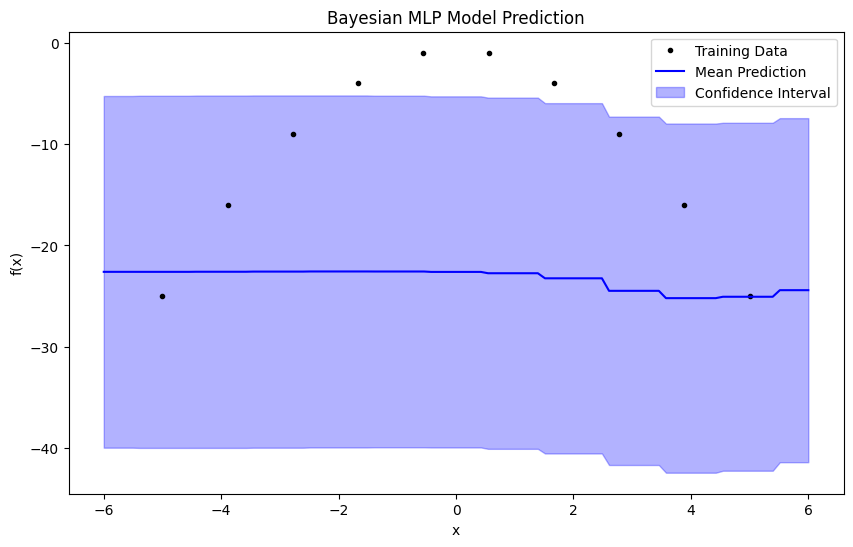

In [49]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood

# Set random seed for reproducibility
torch.manual_seed(0)


trans = InputTransformer(search_space=[-5, 5])

# Generate training data
n_samples = 10  # Number of samples
x_train = torch.linspace(-5, 5, n_samples).unsqueeze(1)  # Inputs: x from -5 to 5
x_train_disc = torch.round(x_train)  # Round the inputs to the nearest integer
def objective_function(x):
    return x**2
objective_function = negate_function(objective_function)
y_train = objective_function(x_train_disc)  # Outputs: f(x) = x^2

# Initialize and train the model
model = BayesianMLPModel(train_X=trans.normalize(x_train_disc), train_Y=y_train, num_hidden_layers=3, hidden_unit_size=64, activation_fn=nn.Tanh())
final_loss = fit_pytorch_model(model, num_epochs=150, learning_rate=0.01)
print(f"Final training loss: {final_loss}")

# Generate test data
x_test = torch.linspace(-6, 6, 100).unsqueeze(1)
x_test_disc = torch.round(x_test)

# Get the model's predictions
model.eval()
with torch.no_grad():
    posterior = model.posterior(trans.normalize(x_test_disc))
    mean_prediction = posterior.mean
    lower, upper = posterior.confidence_region()

# # Generate test data
# x_test = torch.linspace(-6, 6, 100).unsqueeze(1)

# # Get the model's predictions
# model.eval()
# with torch.no_grad():
#     posterior = model.posterior(trans.normalize(x_test))
#     mean_prediction = posterior.mean
#     lower, upper = posterior.confidence_region()

# Plot the true function, predictions, and confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_train.numpy(), 'k.', label='Training Data')
plt.plot(x_test.numpy(), mean_prediction.numpy(), 'b-', label='Mean Prediction')
plt.fill_between(x_test.squeeze().numpy(), lower.numpy(), upper.numpy(), color='blue', alpha=0.3, label='Confidence Interval')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Bayesian MLP Model Prediction')
plt.legend()
plt.show()


Final training loss: 2.594702959060669


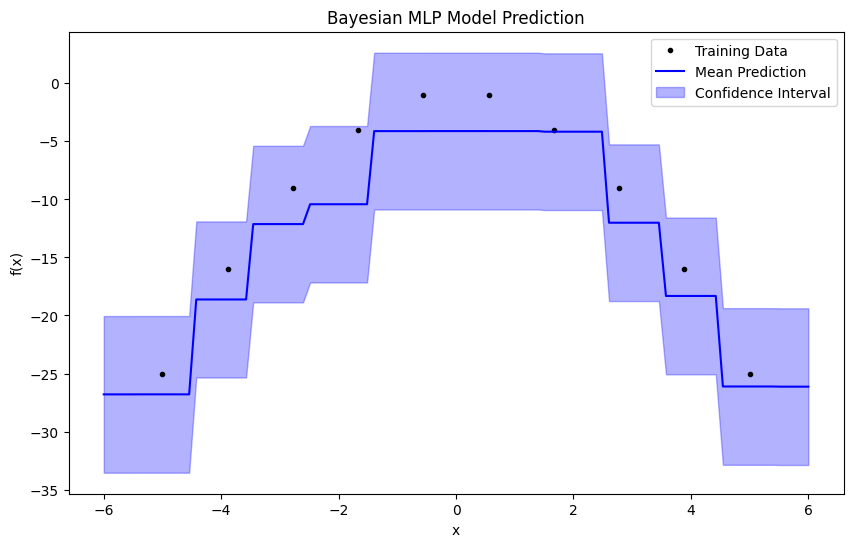

In [57]:

final_loss = fit_pytorch_model(model, num_epochs=150, learning_rate=0.01)
print(f"Final training loss: {final_loss}")

# # Generate test data
# x_test = torch.linspace(-6, 6, 100).unsqueeze(1)
# x_test_disc = torch.round(x_test)

# Get the model's predictions
model.eval()
with torch.no_grad():
    posterior = model.posterior(trans.normalize(x_test_disc))
    mean_prediction = posterior.mean
    lower, upper = posterior.confidence_region()

# # Generate test data
# x_test = torch.linspace(-6, 6, 100).unsqueeze(1)

# # Get the model's predictions
# model.eval()
# with torch.no_grad():
#     posterior = model.posterior(trans.normalize(x_test))
#     mean_prediction = posterior.mean
#     lower, upper = posterior.confidence_region()

# Plot the true function, predictions, and confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_train.numpy(), 'k.', label='Training Data')
plt.plot(x_test.numpy(), mean_prediction.numpy(), 'b-', label='Mean Prediction')
plt.fill_between(x_test.squeeze().numpy(), lower.numpy(), upper.numpy(), color='blue', alpha=0.3, label='Confidence Interval')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Bayesian MLP Model Prediction')
plt.legend()
plt.show()


Final training loss: 3.482009172439575


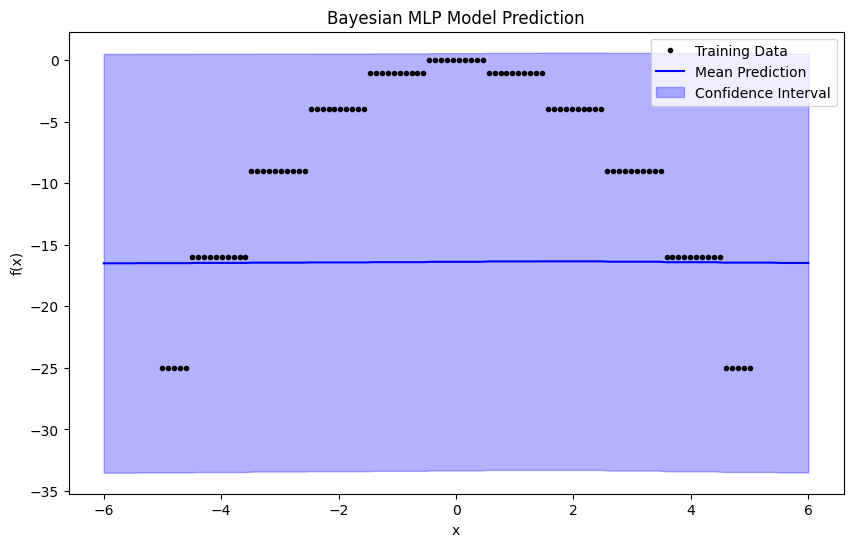

In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood

# Set random seed for reproducibility
torch.manual_seed(0)


trans = InputTransformer(search_space=[-5, 5])

# Generate training data
n_samples = 100  # Number of samples
x_train = torch.linspace(-5, 5, n_samples).unsqueeze(1)  # Inputs: x from -5 to 5
x_train_disc = torch.round(x_train)  # Round the inputs to the nearest integer
def objective_function(x):
    return x**2
objective_function = negate_function(objective_function)
y_train = objective_function(x_train_disc)  # Outputs: f(x) = x^2

# Initialize and train the model
model = BayesianMLPModel(train_X=trans.normalize(x_train_disc), train_Y=y_train, num_hidden_layers=3, hidden_unit_size=64, activation_fn=[nn.ReLU(), nn.ReLU(), nn.Tanh()])
final_loss = fit_pytorch_model(model, num_epochs=150, learning_rate=0.01)
print(f"Final training loss: {final_loss}")

# Generate test data
x_test = torch.linspace(-6, 6, 100).unsqueeze(1)
x_test_disc = torch.round(x_test)

# Get the model's predictions
model.eval()
with torch.no_grad():
    posterior = model.posterior(trans.normalize(x_test_disc))
    mean_prediction = posterior.mean
    lower, upper = posterior.confidence_region()

# # Generate test data
# x_test = torch.linspace(-6, 6, 100).unsqueeze(1)

# # Get the model's predictions
# model.eval()
# with torch.no_grad():
#     posterior = model.posterior(trans.normalize(x_test))
#     mean_prediction = posterior.mean
#     lower, upper = posterior.confidence_region()

# Plot the true function, predictions, and confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_train.numpy(), 'k.', label='Training Data')
plt.plot(x_test.numpy(), mean_prediction.numpy(), 'b-', label='Mean Prediction')
plt.fill_between(x_test.squeeze().numpy(), lower.numpy(), upper.numpy(), color='blue', alpha=0.3, label='Confidence Interval')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Bayesian MLP Model Prediction')
plt.legend()
plt.show()


Final training loss: 1.5391051769256592


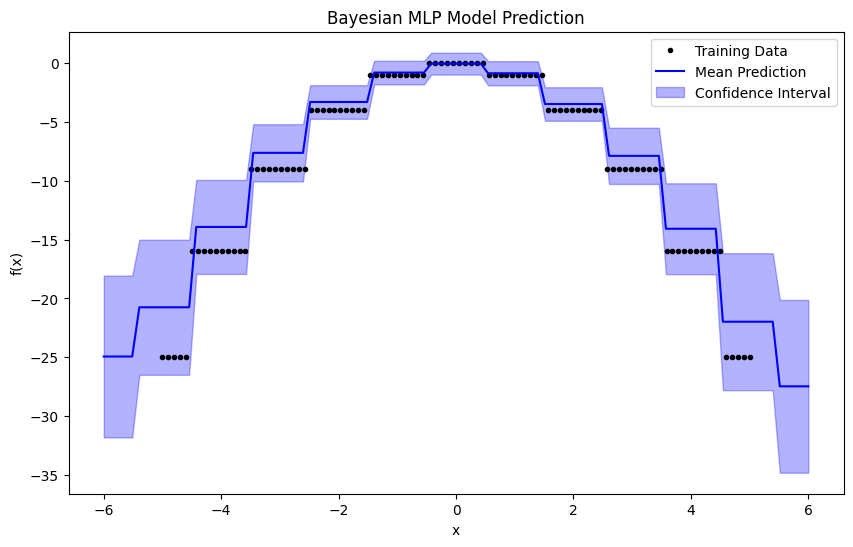

In [25]:

final_loss = fit_pytorch_model(model, num_epochs=150, learning_rate=0.01)
print(f"Final training loss: {final_loss}")

# # Generate test data
# x_test = torch.linspace(-6, 6, 100).unsqueeze(1)
# x_test_disc = torch.round(x_test)

# Get the model's predictions
model.eval()
with torch.no_grad():
    posterior = model.posterior(trans.normalize(x_test_disc))
    mean_prediction = posterior.mean
    lower, upper = posterior.confidence_region()

# # Generate test data
# x_test = torch.linspace(-6, 6, 100).unsqueeze(1)

# # Get the model's predictions
# model.eval()
# with torch.no_grad():
#     posterior = model.posterior(trans.normalize(x_test))
#     mean_prediction = posterior.mean
#     lower, upper = posterior.confidence_region()

# Plot the true function, predictions, and confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_train.numpy(), 'k.', label='Training Data')
plt.plot(x_test.numpy(), mean_prediction.numpy(), 'b-', label='Mean Prediction')
plt.fill_between(x_test.squeeze().numpy(), lower.numpy(), upper.numpy(), color='blue', alpha=0.3, label='Confidence Interval')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Bayesian MLP Model Prediction')
plt.legend()
plt.show()


Final training loss: 3.6634535789489746


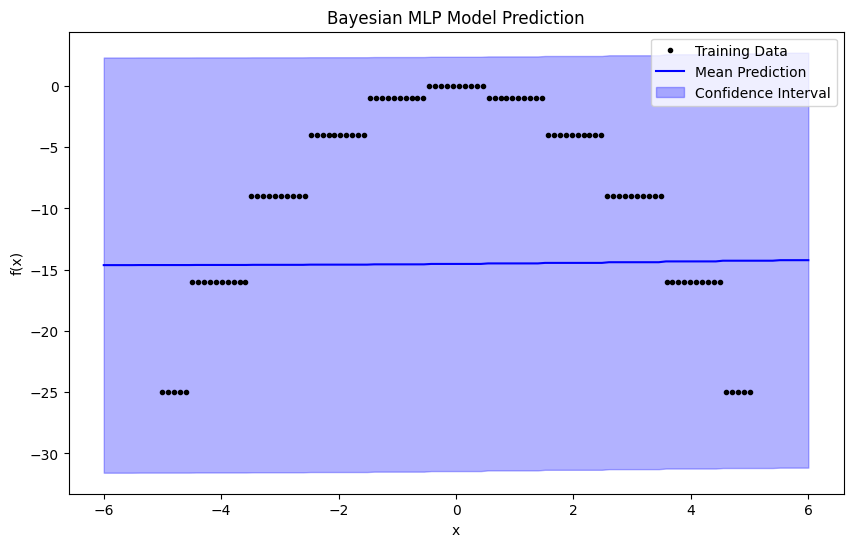

In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood

# Set random seed for reproducibility
torch.manual_seed(0)


trans = InputTransformer(search_space=[-5, 5])

# Generate training data
n_samples = 100  # Number of samples
x_train = torch.linspace(-5, 5, n_samples).unsqueeze(1)  # Inputs: x from -5 to 5
x_train_disc = torch.round(x_train)  # Round the inputs to the nearest integer
def objective_function(x):
    return x**2
objective_function = negate_function(objective_function)
y_train = objective_function(x_train_disc)  # Outputs: f(x) = x^2

# Initialize and train the model
model = BayesianMLPModel(train_X=trans.normalize(x_train_disc), train_Y=y_train, num_hidden_layers=3, hidden_unit_size=64, activation_fn=[nn.ReLU(), nn.Tanh(), nn.Tanh()])
final_loss = fit_pytorch_model(model, num_epochs=150, learning_rate=0.01)
print(f"Final training loss: {final_loss}")

# Generate test data
x_test = torch.linspace(-6, 6, 100).unsqueeze(1)
x_test_disc = torch.round(x_test)

# Get the model's predictions
model.eval()
with torch.no_grad():
    posterior = model.posterior(trans.normalize(x_test_disc))
    mean_prediction = posterior.mean
    lower, upper = posterior.confidence_region()

# # Generate test data
# x_test = torch.linspace(-6, 6, 100).unsqueeze(1)

# # Get the model's predictions
# model.eval()
# with torch.no_grad():
#     posterior = model.posterior(trans.normalize(x_test))
#     mean_prediction = posterior.mean
#     lower, upper = posterior.confidence_region()

# Plot the true function, predictions, and confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_train.numpy(), 'k.', label='Training Data')
plt.plot(x_test.numpy(), mean_prediction.numpy(), 'b-', label='Mean Prediction')
plt.fill_between(x_test.squeeze().numpy(), lower.numpy(), upper.numpy(), color='blue', alpha=0.3, label='Confidence Interval')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Bayesian MLP Model Prediction')
plt.legend()
plt.show()


Final training loss: 1.0055458545684814


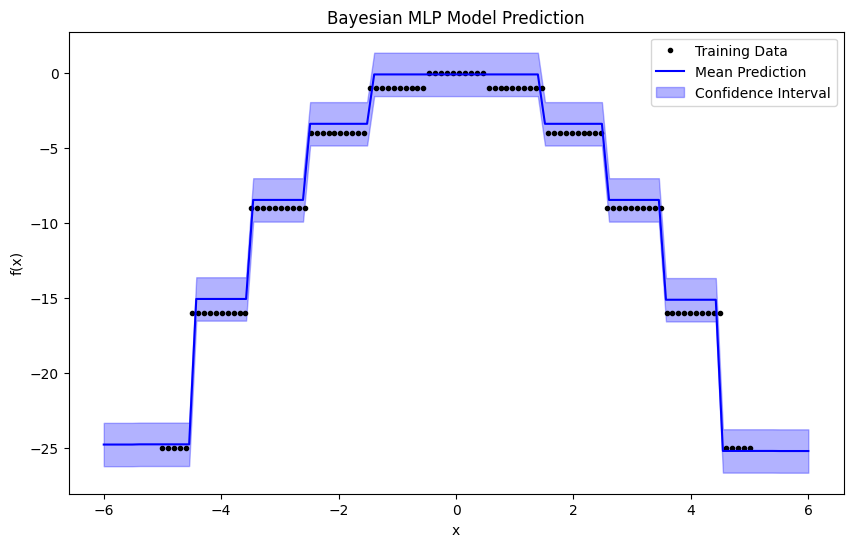

In [36]:

final_loss = fit_pytorch_model(model, num_epochs=150, learning_rate=0.01)
print(f"Final training loss: {final_loss}")

# # Generate test data
# x_test = torch.linspace(-6, 6, 100).unsqueeze(1)
# x_test_disc = torch.round(x_test)

# Get the model's predictions
model.eval()
with torch.no_grad():
    posterior = model.posterior(trans.normalize(x_test_disc))
    mean_prediction = posterior.mean
    lower, upper = posterior.confidence_region()

# # Generate test data
# x_test = torch.linspace(-6, 6, 100).unsqueeze(1)

# # Get the model's predictions
# model.eval()
# with torch.no_grad():
#     posterior = model.posterior(trans.normalize(x_test))
#     mean_prediction = posterior.mean
#     lower, upper = posterior.confidence_region()

# Plot the true function, predictions, and confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_train.numpy(), 'k.', label='Training Data')
plt.plot(x_test.numpy(), mean_prediction.numpy(), 'b-', label='Mean Prediction')
plt.fill_between(x_test.squeeze().numpy(), lower.numpy(), upper.numpy(), color='blue', alpha=0.3, label='Confidence Interval')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Bayesian MLP Model Prediction')
plt.legend()
plt.show()
